# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import random
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    
    return self.out_layer(x, activation=1)

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    predictions = tf.equal(tf.argmax(y_pred, axis=1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(predictions, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)
        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, loss: {loss:.4f}, accuracy: {current_accuracy:.4f}")


Step: 100, loss: 328.4872, accuracy: 0.6914
Step: 200, loss: 195.7990, accuracy: 0.7891
Step: 300, loss: 177.3689, accuracy: 0.7891
Step: 400, loss: 199.3371, accuracy: 0.7969
Step: 500, loss: 137.2972, accuracy: 0.8359
Step: 600, loss: 168.5015, accuracy: 0.8320
Step: 700, loss: 123.0818, accuracy: 0.8438
Step: 800, loss: 131.2545, accuracy: 0.8594
Step: 900, loss: 98.7955, accuracy: 0.8828
Step: 1000, loss: 91.8572, accuracy: 0.8906
Step: 1100, loss: 93.0116, accuracy: 0.8750
Step: 1200, loss: 77.2906, accuracy: 0.9180
Step: 1300, loss: 80.4751, accuracy: 0.8828
Step: 1400, loss: 83.5909, accuracy: 0.9023
Step: 1500, loss: 90.3913, accuracy: 0.8828
Step: 1600, loss: 62.1420, accuracy: 0.9062
Step: 1700, loss: 66.7498, accuracy: 0.9102
Step: 1800, loss: 126.4137, accuracy: 0.8711
Step: 1900, loss: 42.0226, accuracy: 0.9570
Step: 2000, loss: 69.2275, accuracy: 0.8906
Step: 2100, loss: 53.0817, accuracy: 0.9336
Step: 2200, loss: 84.7894, accuracy: 0.8945
Step: 2300, loss: 67.8797, accur

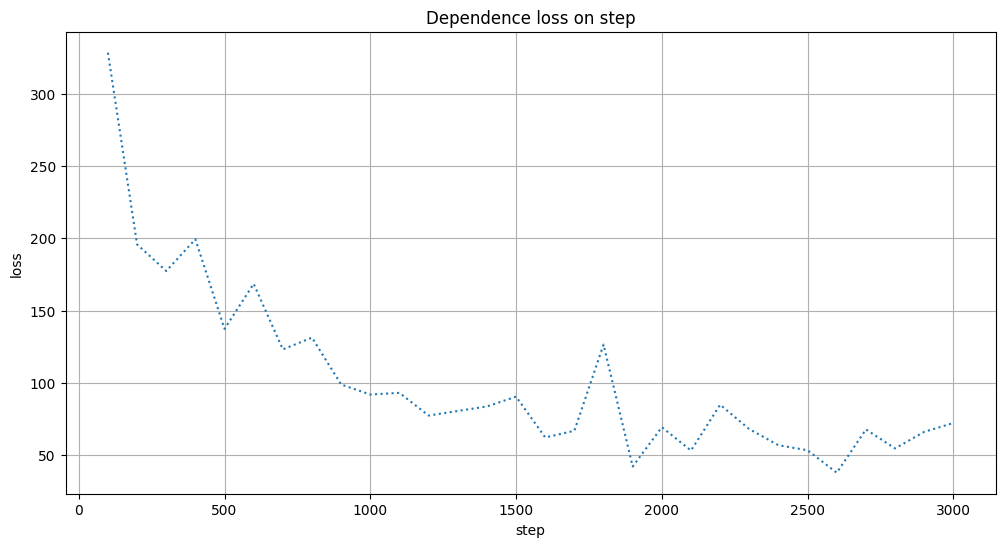

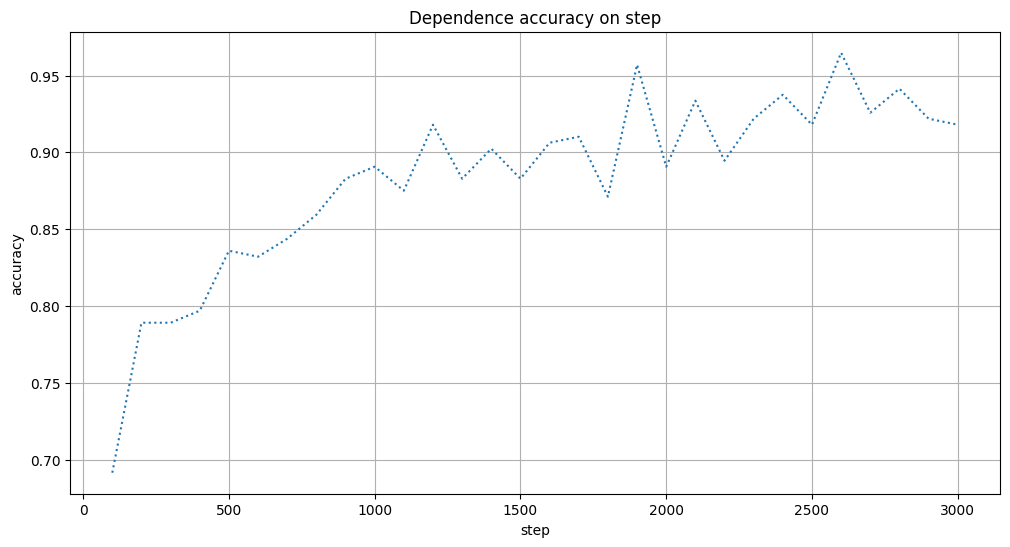

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

def show_plt(history, name):
    plt.figure(figsize=(12,6))
    plt.plot(range(100, 3001, 100), history, linestyle=":")
    plt.title(f'Dependence {name} on step')
    plt.xlabel('step')
    plt.ylabel(f'{name}')
    plt.grid()
    plt.show()
    
# Виведіть графік функції втрат
show_plt(loss_history, "loss")

# Виведіть графік точності
show_plt(accuracy_history, "accuracy")


Neural Network Accuracy: 0.9212999939918518
Test digit: 7
Neural Network predicted digit: 7
Picture of digit:


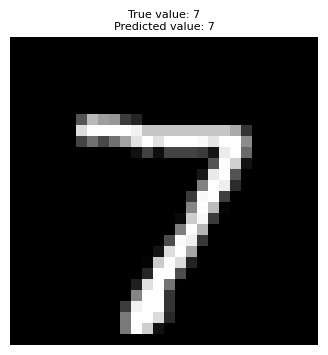

In [9]:
# Обчисліть точність навченої нейромережі
accuracy_neural_network = accuracy(neural_net(x_train), y_train)
print(f"Neural Network Accuracy: {accuracy_neural_network}")
# Тестування моделі на тестових даних
some_digit = random.randint(0, 9)
test_image = x_test[some_digit].reshape(1, -1)
test_digit = y_test[some_digit]

p_pred = neural_net(test_image)

y_pred = p_pred[0].numpy()
predicted_digit = y_pred.argmax()

print(f'Test digit: {test_digit}')
print(f'Neural Network predicted digit: {predicted_digit}')
print(f'Picture of digit:')

plt.figure(figsize=(4, 4))
plt.imshow(test_image[0].reshape((28, 28)), cmap='gray')
plt.title(f"True value: {test_digit}\nPredicted value: {predicted_digit}", fontsize=8)
plt.axis('off')
plt.show()

Accuracy of tested data: 0.9000


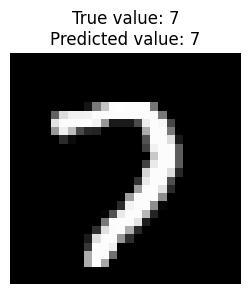

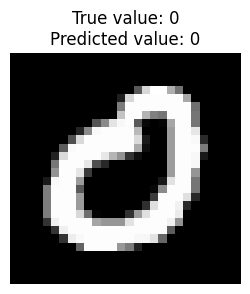

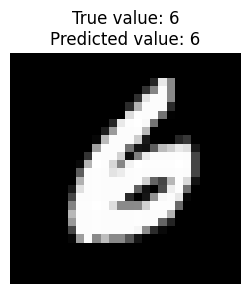

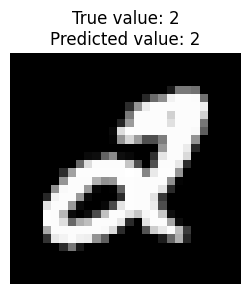

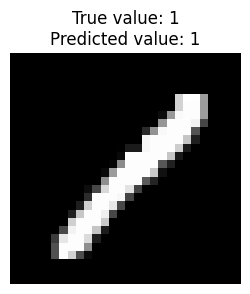

In [10]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

num_test_samples = 10
correct_predictions = 0

for i in range(num_test_samples):
    some_digit = random.randint(0, len(x_test) - 1)
    test_image = x_test[some_digit].reshape(1, -1)
    test_digit = y_test[some_digit]
    p_pred = neural_net(test_image)
    y_pred = p_pred[0].numpy()
    predicted_digit = y_pred.argmax()
    correct_predictions += (predicted_digit == test_digit)

accuracy_on_test = correct_predictions / num_test_samples
print(f"Accuracy of tested data: {accuracy_on_test:.4f}")

for i in random.sample(range(len(x_test)), 5):
    test_image = x_test[i].reshape(1, -1)
    test_digit = y_test[i]
    p_pred = neural_net(test_image)
    y_pred = p_pred[0].numpy()
    predicted_digit = y_pred.argmax()
    correct_predictions += (predicted_digit == test_digit)

    plt.figure(figsize=(3, 3))
    plt.imshow(test_image[0].reshape((28, 28)), cmap='gray')
    plt.title(f"True value: {test_digit}\nPredicted value: {predicted_digit}")
    plt.axis('off')
    plt.show()

In [11]:
y_pred_list = []
y_true_list = []

for i in range(len(x_test)):
    test_image = x_test[i].reshape(1, -1)
    test_digit = y_test[i]
    p_pred = neural_net(test_image)
    y_pred = p_pred[0].numpy()
    predicted_digit = y_pred.argmax()
    y_pred_list.append(predicted_digit)
    y_true_list.append(test_digit)

report = classification_report(y_true_list, y_pred_list, target_names=[str(i) for i in range(num_classes)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.88      0.90      0.89      1032
           3       0.89      0.89      0.89      1010
           4       0.88      0.88      0.88       982
           5       0.88      0.85      0.87       892
           6       0.95      0.92      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.85      0.88      0.87       974
           9       0.87      0.88      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Висновок

Тестуючи нейромережу декілька разів, переконався що вона працює у відповідності до визначеної якості, а саме до рівня точності визначеної у 90%. Бувають деякі помилки, через те, що деякі тестові цифри візуально схожі одна на одну.